### MLBS reproduction of results 
Ayna, C. O., Mdrafi, R., Du, Q., & Gurbuz, A. C. (2023). Learning-Based Optimization of Hyperspectral Band Selection for Classification. Remote Sensing, 15(18), 4460. https://doi.org/10.3390/rs15184460


Ran on Kaggle: https://www.kaggle.com/code/dikramasrour/mlbs-band-selection-baseline-experiment/notebook?scriptVersionId=157413564

In [153]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indianpines/IndianPines/Indian_pines_corrected.mat
/kaggle/input/indianpines/IndianPines/Indian_pines_gt.mat


In [154]:
# Importing the libraries
import tensorflow as tf
import numpy as np
import os, sys
import scipy.io as sio
from math import ceil
import matplotlib.pyplot as plt

In [155]:
# HYPERPARAMS

# Initializing constants
# IndianPines dataset
DATASET_NAME = 'IP' 
K = 10
K_NUM = 1

# The ratio of the training dataset over the whole points.
TRAINING_RATIO = 0.25                       
pmask_slope = 5
sample_slope = 200
BS = 30

EPOCHS = 150
LR = 0.001
BATCH_SIZE = 16

In [156]:
# Utils
""" Data preprocessing functions """
def read_data(dataset_name):                        # Loads Dataset
    # path = os.getcwd()
    if dataset_name == 'IP':
        image = sio.loadmat("/kaggle/input/indianpines/IndianPines/Indian_pines_corrected.mat")["indian_pines_corrected"]
        label = sio.loadmat("/kaggle/input/indianpines/IndianPines/Indian_pines_gt.mat")["indian_pines_gt"]
#         image = sio.loadmat("..\\source_code\\datasets\\IndianPines\\Indian_pines_corrected.mat")["indian_pines_corrected"]
#         label = sio.loadmat("..\\source_code\\datasets\\IndianPines\\Indian_pines_gt.mat")["indian_pines_gt"]
    elif dataset_name == 'UP':
        image = sio.loadmat('..\\source_code\\datasets\\PaviaUniversity\\PaviaU.mat')['paviaU']
        label = sio.loadmat('..\\source_code\\datasets\\PaviaUniversity\\PaviaU_gt.mat')['paviaU_gt']
    image = np.float64(image)
    label = np.array(label).astype(float)
    return image, label

def normalize_dataset(data):                        # Dataset Min-Max Normalization
    max_val = np.amax(data, axis=(0,1,2))
    min_val = np.amin(data, axis=(0,1,2))
    data_norm = (data - min_val) / (max_val - min_val)
    return data_norm

# Separates the dataset into training and test sets
# ! Pretty much useless method
def separate_train_test(data, labels, p):   
    '''
    data: HSI image (x, y, z), x and y being pixel coordinates and z being the number of spectral bands
    labels: pixels labels matrix as provided in dataset
    p: proportion (ratio) of training set
    '''
    c = int(labels.max())
    x = np.array([], dtype=float).reshape(-1, data.shape[2])
    xb = []
    x_loc1 = []
    x_loc2 = []
    x_loc = []
    y = np.array([], dtype=float).reshape(-1, data.shape[2])
    yb = []
    y_loc1 = []
    y_loc2 = []
    y_loc = []
    for i in range(1, c+1):
        # label coordinates
        loc1, loc2 = np.where(labels == i)
        # label frequency
        num = len(loc1)                     
        order = np.random.permutation(range(num))
        loc1 = loc1[order]
        loc2 = loc2[order]
        # number of training samples to be selected for each label
        num1 = int(np.round(num*p))
        x = np.vstack([x, data[loc1[:num1], loc2[:num1], :]])
        y = np.vstack([y, data[loc1[num1:], loc2[num1:], :]])
        xb.extend([i]*num1)
        yb.extend([i]*(num-num1))
        x_loc1.extend(loc1[:num1])
        x_loc2.extend(loc2[:num1])
        y_loc1.extend(loc1[num1:])
        y_loc2.extend(loc2[num1:])
        x_loc = np.vstack([x_loc1, x_loc2])
        y_loc = np.vstack([y_loc1, y_loc2])
    return x, xb, x_loc, y, yb, y_loc

def one_hot(lable,class_number):            # One-hot converter
    one_hot_array = np.zeros([len(lable),class_number])
    for i in range(len(lable)):
        one_hot_array[i,int(lable[i]-1)] = 1
    return one_hot_array

def disorder(X,Y,loc):
    index_train = np.arange(X.shape[0])
    np.random.shuffle(index_train)
    X = X[index_train, :]
    Y = Y[index_train, :]
    loc = loc[:,index_train]
    return X,Y,loc

# when w=1, windowFeature performs a train/test split
def windowFeature(data, loc, w):
    size = np.shape(data)
    data_expand = np.zeros((int(size[0]+w-1),int(size[1]+w-1),size[2]))
    newdata = np.zeros((len(loc[0]), w, w,size[2]))
    # for each spectral band
    for j in range(size[2]):    
        data_expand[:,:,j] = np.lib.pad(data[:,:,j], ((int(w / 2), int(w / 2)), (int(w / 2),int(w / 2))), 'symmetric')
        newdata[:,:,:,j] = np.zeros((len(loc[0]), w, w))
        # for each training sample
        for i in range(len(loc[0])):
            loc1 = loc[0][i]
            loc2 = loc[1][i]
            f = data_expand[loc1:loc1 + w, loc2:loc2 + w,j]
            newdata[i, :, :,j] = f
    return newdata

In [171]:
"""
Functions of the probability mask as described in the paper.
Each weight is passed into a sigmoid to convert them to a probability representation.
"""
class ProbMask(tf.keras.layers.Layer):
    def __init__(self, slope, filter_size, **kwargs):
        self.slope = tf.Variable(slope, dtype=tf.float32)
        self.P = filter_size
        
        w_init = tf.random_uniform_initializer(minval=0, maxval=1)
        self.w = tf.Variable(w_init(shape=(1, filter_size, 1)))
        # Inverse Tranform Sampling (https://en.wikipedia.org/wiki/Inverse_transform_sampling)
        self.w = tf.Variable(- tf.math.log(1. / self.w - 1.) / self.slope)
        super(ProbMask, self).__init__(**kwargs) 
        
    def build(self, input_shape):
        super(ProbMask, self).build(input_shape)
        
    def call(self, input_tensor):
        weights = self.w
        return tf.sigmoid(self.slope * weights)

    def compute_output_shape(self, input_shape):
        lst = list(input_shape)
        lst[-1] = 1
        return tuple(lst)
    
# (Normalisation layer) rescales the weights given a sparsity level in probability map.
class RescaleProbMask(tf.keras.layers.Layer):
    def __init__(self, sparsity, **kwargs):
        self.alpha = tf.constant(sparsity, dtype=tf.float32)
        super(RescaleProbMask, self).__init__(**kwargs)

    def build(self, input_shape):
        self.num = input_shape[2]
        super(RescaleProbMask, self).build(input_shape)

    def call(self, input_tensor):
        prob_map = self.force_sparsity(input_tensor, alpha = self.alpha)
        return prob_map

    # Paper: Sec3.1: Eq(5): making opt prob unconstrained
    def force_sparsity(self, pixel, alpha):
        p = tf.math.reduce_mean(pixel, axis=1)
        beta = (1 - alpha) / (1 - p)
        le = tf.cast(tf.greater_equal(p, alpha), tf.float32)
        return (le * pixel * alpha) / p + (1 - le) * (1 - beta * (1 - pixel))

class ThresholdRandomMask(tf.keras.layers.Layer):
    def __init__(self, slope = 12, **kwargs):
        self.slope = None
        if slope is not None:
            self.slope = tf.Variable(slope, dtype=tf.float32) 
        super(ThresholdRandomMask, self).__init__(**kwargs)

    def build(self, input_shape):
        filter_size = input_shape[1]
        t_init = tf.random_uniform_initializer(minval=0, maxval=1)
        threshold = tf.constant(t_init(shape=(1, filter_size, 1)))
        self.thresh = threshold
        super(ThresholdRandomMask, self).build(input_shape)

    def call(self, inputs):
        #thresh = tf.zeros_like(inputs)
        if self.slope is not None:
            return tf.sigmoid(self.slope * (inputs-self.thresh)) 
        else:  
            # FOR INFERENCE 
            print('inference')
            return inputs > self.thresh

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
# The layer that performs masking operation.
class UnderSample(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UnderSample, self).__init__(**kwargs)

    def build(self, input_shape):
        super(UnderSample, self).build(input_shape)

    def call(self, inputs):
        input_pix = inputs[0]
        mask = inputs[1]
        image_masked = tf.multiply(input_pix, mask)
        return image_masked

# Learning rate scheduler 
def scheduler(epoch, lr):
    if epoch == 50:
        lr = lr / 10
    if epoch == 100:
        lr = lr / 10
    return lr

In [158]:
# Importing and modifying data
data_ori, labels_ori = read_data(DATASET_NAME)

train_x, train_y, train_loc, test_x, test_y, test_loc = separate_train_test(data_ori, labels_ori, TRAINING_RATIO)

# number of classes
num_classification = int(np.max(labels_ori))
num_classification

16

In [159]:
data_ori.shape

(145, 145, 200)

In [160]:
X_train = windowFeature(data_ori, train_loc, 1)
X_test = windowFeature(data_ori, test_loc, 1)
X_train.shape, X_test.shape 

((2562, 1, 1, 200), (7687, 1, 1, 200))

In [161]:
X_train = np.squeeze(X_train, axis=2)
X_test = np.squeeze(X_test, axis=2)
X_train.shape, X_test.shape 

((2562, 1, 200), (7687, 1, 200))

In [162]:
Y_train = one_hot(train_y,num_classification)
Y_train_int = np.argmax(Y_train, axis=1)
Y_test = one_hot(test_y,num_classification)
Y_train.shape, Y_test.shape

((2562, 16), (7687, 16))

In [163]:
# Data normalisation (after splitting)
X_train_norm = normalize_dataset(X_train)
X_test_norm = normalize_dataset(X_test)

In [164]:
X_train, Y_train, train_loc = disorder(X_train_norm, Y_train, train_loc)
X_test, Y_test, test_loc = disorder(X_test_norm, Y_test, test_loc)

X_train = np.transpose(X_train, axes=(0,2,1))
X_test = np.transpose(X_test, axes=(0,2,1))

In [165]:
X_train.shape, X_test.shape

((2562, 200, 1), (7687, 200, 1))

In [166]:
# Number of training samples (training pixels)
num_train_data = X_train.shape[0]  
# Number of bands
num_band = X_train.shape[1]   
# Number of classes          
num_class = Y_train.shape[1]

# Class weights
number_class_label = []; class_weights = []
for i in range(num_class):
    # per class frequency in training set
    number_class_label.append(len(np.where(Y_train_int == i)[0]))
    # weight given to class i
    class_weights.append(num_train_data/number_class_label[i])

class_weights = np.array(class_weights)
class_weights_norm = class_weights / np.sum(class_weights)
class_weights_norm = np.sqrt(class_weights_norm)
# class_weights_norm = np.square(class_weights_norm)
class_weights_dic = {}
for i in range(num_class):
    class_weights_dic[i] = 100 * class_weights_norm[i]

print('Shape of the training images: ', X_train[0].shape)
print('Shape of the test images: ', X_test[0].shape)
print('Number of the train samples', X_train.shape[0])
print('Number of the test samples', X_test.shape[0])
print('Number of the classes', num_classification)
print('Class weights dict', class_weights_dic)

Shape of the training images:  (200, 1)
Shape of the test images:  (200, 1)
Number of the train samples 2562
Number of the test samples 7687
Number of the classes 16
Class weights dict {0: 38.506837354843995, 1: 7.059831985699054, 2: 9.2490431617559, 3: 17.366106809231667, 4: 12.12650886134199, 5: 9.887643047649991, 6: 50.41728484340734, 7: 12.17693115309604, 8: 59.65453591617137, 9: 8.557074967743109, 10: 5.383246764527845, 11: 10.964721769947355, 12: 18.678559732059004, 13: 7.503863620202448, 14: 13.614222907828822, 15: 27.81407078758715}


In [167]:
# Band selection network
input_image = tf.keras.Input(shape=(num_band, 1), name = 'input_image')

prob_mask_tensor = ProbMask(slope=pmask_slope, filter_size=num_band, name='prob_mask')(input_image)
thresh_tensor = RescaleProbMask(sparsity = BS/num_band, name='rescaled_mask')(prob_mask_tensor)
tensor_mask = ThresholdRandomMask(slope = sample_slope, name='sampled_mask')(thresh_tensor) 
last_tensor = UnderSample(name='proxy_data')([input_image, tensor_mask])

In [168]:
# Downstream network: pixel classification
X=tf.keras.layers.Conv1D(64, 15, activation='relu',padding='Same')(last_tensor)
X=tf.keras.layers.Conv1D(64, 15, activation='relu',padding='Same')(X)   
X=tf.keras.layers.Conv1D(64, 15, activation='relu',padding='Same')(X)
M=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2, padding='Same')(X)
X=tf.keras.layers.Conv1D(32, 9, activation='relu',padding='Same')(M)
X=tf.keras.layers.Conv1D(32, 9, activation='relu',padding='Same')(X)   
X=tf.keras.layers.Conv1D(32, 9, activation='relu',padding='Same')(X)
M=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2, padding='Same')(X)
Z=tf.keras.layers.Flatten()(M)
Y=tf.keras.layers.Dense(32, activation='relu')(Z)
#Y=tf.keras.layers.Dropout(0.2)(Y)
output_layer=tf.keras.layers.Dense(num_classification, activation='softmax')(Y)

In [169]:
model = tf.keras.Model(inputs=input_image, outputs=output_layer)
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 prob_mask (ProbMask)        (1, 200, 1)                  201       ['input_image[0][0]']         
                                                                                                  
 rescaled_mask (RescaleProb  (1, 200, 1)                  0         ['prob_mask[0][0]']           
 Mask)                                                                                            
                                                                                                  
 sampled_mask (ThresholdRan  (1, 200, 1)                  1         ['rescaled_mask[0][0]'] 

In [172]:
history = model.fit(x = X_train, y = Y_train,
          validation_data = (X_test, Y_test), 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          steps_per_epoch=ceil(num_train_data/BATCH_SIZE),
          callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)],
          class_weight = class_weights_dic)

Epoch 1/150
161/161 [==============================] - 2s 14ms/step - loss: 5.2822 - accuracy: 0.7479 - val_loss: 0.7759 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 2/150
161/161 [==============================] - 2s 15ms/step - loss: 5.6623 - accuracy: 0.7404 - val_loss: 0.9947 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 3/150
161/161 [==============================] - 2s 14ms/step - loss: 6.6941 - accuracy: 0.7213 - val_loss: 0.7971 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 4/150
161/161 [==============================] - 2s 14ms/step - loss: 5.1761 - accuracy: 0.7545 - val_loss: 0.8359 - val_accuracy: 0.6998 - lr: 0.0010
Epoch 5/150
161/161 [==============================] - 2s 14ms/step - loss: 5.2704 - accuracy: 0.7482 - val_loss: 0.8260 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 6/150
161/161 [==============================] - 3s 16ms/step - loss: 5.2078 - accuracy: 0.7518 - val_loss: 0.8574 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 7/150
161/161 [==============================] - 2s 

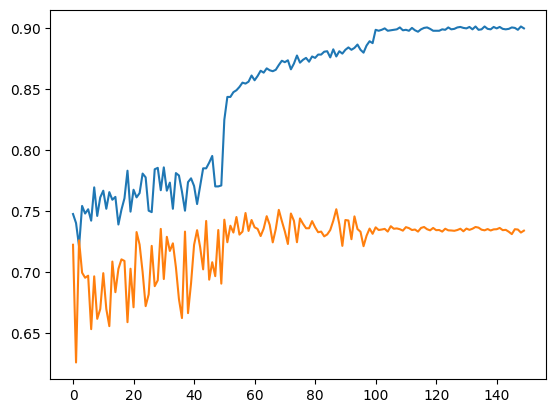

In [173]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [174]:
model.save("hbs_mlbs_" + DATASET_NAME)
np.save("image_train_" + DATASET_NAME, X_train);np.save("label_train_" + DATASET_NAME, Y_train)
np.save("image_test_" + DATASET_NAME, X_test);np.save("label_test_" + DATASET_NAME, Y_test)

In [175]:
import time
# Model and dataset addresses
# MODEL_ADDRESS = "hbs_mlbs_"+DATASET_NAME
# DATASET_ADDRESS = ["hbs_mlbs_"+DATASET_NAME+"\\image_train_"+DATASET_NAME+".npy",
#                    "hbs_mlbs_"+DATASET_NAME+"\\label_train_"+DATASET_NAME+".npy",
#                    "hbs_mlbs_"+DATASET_NAME+"\\image_test_"+DATASET_NAME+".npy",
#                    "hbs_mlbs_"+DATASET_NAME+"\\label_test_"+DATASET_NAME+".npy"]

MODEL_ADDRESS = "/kaggle/working/hbs_mlbs_" + DATASET_NAME
DATASET_ADDRESS = ["/kaggle/working/image_train_IP.npy",
                   "/kaggle/working/label_train_IP.npy",
                   "/kaggle/working/image_test_IP.npy",
                   "/kaggle/working/label_test_IP.npy"]

# Loading the test dataset.
model = tf.keras.models.load_model(MODEL_ADDRESS)
image_test = np.load(DATASET_ADDRESS[2])
label_test = np.load(DATASET_ADDRESS[3])
label_test_int = np.argmax(label_test, axis=1)

start_time = time.time()
pred = model.predict(image_test)
# model.predict([image_test[0][np.newaxis], image_test[0][np.newaxis]])
end_time = time.time()

y_pred = np.argmax(pred, axis=1) 

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 

241/241 [==============================] - 1s 2ms/step
Elapsed time:  0.8176891803741455


              precision    recall  f1-score   support

           0       0.56      0.85      0.67        34
           1       0.79      0.44      0.57      1071
           2       0.60      0.59      0.59       622
           3       0.74      0.41      0.53       178
           4       0.80      0.85      0.82       362
           5       0.83      0.90      0.86       548
           6       0.73      0.52      0.61        21
           7       0.98      0.89      0.94       358
           8       0.75      0.60      0.67        15
           9       0.60      0.74      0.66       729
          10       0.68      0.81      0.74      1841
          11       0.67      0.69      0.68       445
          12       0.90      0.97      0.93       154
          13       0.90      0.91      0.91       949
          14       0.54      0.52      0.53       290
          15       1.00      0.93      0.96        70

    accuracy                           0.73      7687
   macro avg       0.76   

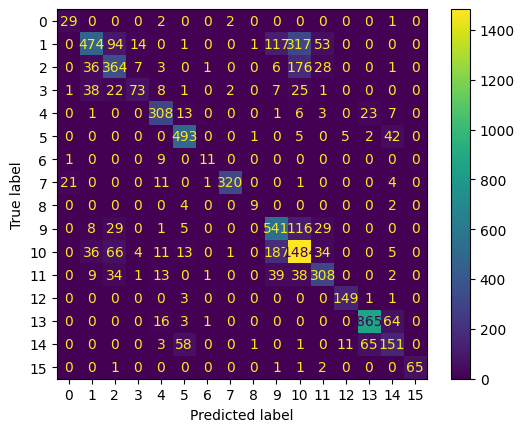

In [176]:
import sklearn.metrics as metrics

print(metrics.classification_report(label_test_int, y_pred))
cm = metrics.confusion_matrix(label_test_int, y_pred)
plot = metrics.ConfusionMatrixDisplay(cm)
plot.plot()